In [10]:
import os
import sys
import json
import time
import ffmpeg
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn.utils.spectral_norm as spectralnorm
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from PIL import Image
from pytorch_msssim import ssim
import lpips

from models import *
from utils import *
from helper import *
from vimeo90k import Vimeo90kDataset, VideoFolder_diffusion

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.models.image_model import IntraNoAR
from DCVC_HEM.src.utils.stream_helper import get_state_dict


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
!nvidia-smi


Tue Jan 28 13:11:48 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:2F:00.0 Off |                    0 |
| N/A   35C    P8    15W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

In [12]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

lpips_vgg = lpips.LPIPS(net='vgg').to(device)
def LPIPS(img1, img2):
    lpips = lpips_vgg(img1, img2)
    return lpips.mean().item()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/lpips/weights/v0.1/vgg.pth


In [5]:
def run_h264(frames, crf=100, preset="veryslow"):
    height, width = frames.shape[1], frames.shape[2]
    
    frames = (frames * 255).clamp(0, 255).squeeze().cpu().numpy()
    process = (
        ffmpeg
        .input('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .output(
            'pipe:', vcodec='libx264', pix_fmt='gray', 
            crf=crf, preset=preset, format='h264')        
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    for frame in frames:
        frame = frame.astype(np.uint8)
        process.stdin.write(frame.tobytes())
    
    process.stdin.close()
    compressed_output = process.stdout.read()
    compressed_videos = np.frombuffer(compressed_output, dtype=np.uint8)
    
    frame_sizes = []
    i = 0
    while i < len(compressed_videos):
        if i + 4 < len(compressed_videos) and compressed_videos[i:i + 4].tolist() == [0, 0, 0, 1]:
            start = i
            i += 4
            while i + 4 < len(compressed_videos) and compressed_videos[i:i + 4].tolist() != [0, 0, 0, 1]:
                i += 1
            end = i
            frame_sizes.append(end - start)
        else:
            i += 1

    bits = [size * 8 for size in frame_sizes][1:]
    for idx, bitrate in enumerate(bits):
        print(f"H.264: Frame {idx + 1}: {bitrate} bits")

    process_decode = (
        ffmpeg
        .input('pipe:', format='h264')
        .output('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    process_decode.stdin.write(compressed_output)
    process_decode.stdin.close()

    decomp_output = process_decode.stdout.read()

    num_frames = len(decomp_output) // (height * width)
    recon_frames = np.frombuffer(decomp_output, dtype=np.uint8).reshape(num_frames, height, width)
    
    recon_frames = torch.from_numpy(recon_frames).float().to(device)
    recon_frames = recon_frames / 255.
    
    x0_hat = recon_frames[0, :, :].unsqueeze(0)
    x1_hat = recon_frames[1, :, :].unsqueeze(0)
    x2_hat = recon_frames[2, :, :].unsqueeze(0)
    
    return x0_hat, x1_hat, x2_hat

In [17]:
model_path = './DCVC_HEM/checkpoints/dcvc-hem_bit-lamb-2_ft_epoch_5.pth'

p_frame_y_q_scales, p_frame_mv_y_q_scales = DMC.get_q_scales_from_ckpt(model_path)

p_state_dict = get_state_dict(model_path)
video_net = DMC()
video_net.load_state_dict(p_state_dict)
video_net = video_net.to(device)
video_net.eval()

def run_dcvc_test(x1_hat, x2):
    x1_hat = x1_hat.repeat(1, 3, 1, 1)
    x2 = x2.repeat(1, 3, 1, 1)

    rate_idx = 0

    p_frame_y_q_scale = torch.tensor(4.5) # p_frame_y_q_scales[rate_idx]
    p_frame_mv_y_q_scale = torch.tensor(4.5) # p_frame_y_q_scales[rate_idx]

    with torch.no_grad():
        pic_height = x2.shape[2]
        pic_width = x2.shape[3]

        bin_path = None

        dpb = {
            "ref_frame": x1_hat,
            "ref_feature": None,
            "ref_y": None,
            "ref_mv_y": None,
        }

        x2_result = video_net.encode_decode(
            x2, dpb, bin_path,
            pic_height=pic_height, pic_width=pic_width,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x2_result["dpb"]
        x2_hat = dpb["ref_frame"]
        x2_hat = x2_hat.clamp_(0, 1)
    
    # print("DCVC bitrates: ", x2_result['bit'])

    return x2_hat.mean(dim=1, keepdim=True)

In [7]:
def plot_inf_eps1_eps2(
    x0, x1, x2, 
    x1_JD, x1_AR, x1_FMD, x1_MSE,
    x2_JD, x2_AR, x2_FMD, x2_MSE,
    x2_DCVC, 
    eps1, eps2, step
):
    fig, axarr = plt.subplots(
        6, 5, dpi=250, 
        gridspec_kw={
            'wspace': 0.0, 'hspace': 0.01, 'width_ratios': [0.2, 1, 1, 1, 1]}
    )
    fig.set_size_inches(6.95, 10.27)
    
    plt.rcParams.update({
        'font.family': 'FreeSerif',
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'FreeSerif',
        'mathtext.it': 'FreeSerif:italic',
        'mathtext.bf': 'FreeSerif:bold',
    })
    
    for i in range(6):
        for j in range(5):
            axarr[i,j].axis('off')

    fontsize = 16
    axarr[0, 1].set_title(r"$X_1$", fontsize=fontsize)
    axarr[0, 2].set_title(r"$X_2$", fontsize=fontsize)
    axarr[0, 3].set_title(r"$X_3$", fontsize=fontsize)
    axarr[0, 4].set_title(r"Trajectory", fontsize=fontsize)
    
    axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[0, 0].transAxes, fontsize=fontsize)
    axarr[1, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[1, 0].transAxes, fontsize=fontsize)
    axarr[2, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[2, 0].transAxes, fontsize=fontsize)
    axarr[3, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[3, 0].transAxes, fontsize=fontsize)
    axarr[4, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[4, 0].transAxes, fontsize=fontsize)
    axarr[5, 0].text(0.5, 0.5, r"0-PLF-SA", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[5, 0].transAxes, fontsize=fontsize)
    
    zeros = torch.zeros_like(x0)
    x0_img = torch.cat((x0, zeros, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x1_img = torch.cat((zeros, x1, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_img = torch.cat((zeros, zeros, x2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    or_t = torch.cat((x0, x1, x2), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_MSE_img = torch.cat((zeros, x1_MSE, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_MSE_img = torch.cat((zeros, zeros, x2_MSE), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    mse_t = torch.cat((x0, x1_MSE, x2_MSE), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_JD_img = torch.cat((zeros, x1_JD, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_JD_img = torch.cat((zeros, zeros, x2_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    jd_t = torch.cat((x0, x1_JD, x2_JD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_AR_img = torch.cat((zeros, x1_AR, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_AR_img = torch.cat((zeros, zeros, x2_AR), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    ar_t = torch.cat((x0, x1_AR, x2_AR), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x1_FMD_img = torch.cat((zeros, x1_FMD, zeros), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    x2_FMD_img = torch.cat((zeros, zeros, x2_FMD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    fmd_t = torch.cat((x0, x1_FMD, x2_FMD), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    
    x2_dcvc_img = torch.cat((zeros, zeros, x2_DCVC), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()
    dcvc_t = torch.cat((x0, x1_JD, x2_DCVC), dim=0).squeeze().cpu().data.permute(1, 2, 0).numpy()

    axarr[0, 1].imshow(x0_img)
    axarr[0, 2].imshow(x1_img)
    axarr[0, 3].imshow(x2_img)
    axarr[0, 4].imshow(or_t)
    
    axarr[1, 1].imshow(x0_img)
    axarr[1, 2].imshow(x1_JD_img)
    axarr[1, 3].imshow(x2_dcvc_img)
    axarr[1, 4].imshow(dcvc_t)
    
    axarr[2, 1].imshow(x0_img)
    axarr[2, 2].imshow(x1_MSE_img)
    axarr[2, 3].imshow(x2_MSE_img)
    axarr[2, 4].imshow(mse_t)
    
    axarr[3, 1].imshow(x0_img)
    axarr[3, 2].imshow(x1_FMD_img)
    axarr[3, 3].imshow(x2_FMD_img)
    axarr[3, 4].imshow(fmd_t)
    
    axarr[4, 1].imshow(x0_img)
    axarr[4, 2].imshow(x1_JD_img)
    axarr[4, 3].imshow(x2_JD_img)
    axarr[4, 4].imshow(jd_t)
    
    axarr[5, 1].imshow(x0_img)
    axarr[5, 2].imshow(x1_AR_img)
    axarr[5, 3].imshow(x2_AR_img)
    axarr[5, 4].imshow(ar_t)
    
    save_path = f'./reconstructions/inf-eps1-eps2/inf-{eps1}-{eps2}/step{step}/'
    os.makedirs(save_path, exist_ok=True)
                      
    plt.imsave(save_path + "x0.png", x0_img)
    plt.imsave(save_path + "x1.png", x1_img)
    plt.imsave(save_path + "x2.png", x2_img)
    plt.imsave(save_path + "traj.png", or_t)
    
    plt.imsave(save_path + "x1_MSE.png", x1_MSE_img)
    plt.imsave(save_path + "x2_MSE.png", x2_MSE_img)
    plt.imsave(save_path + "traj_MSE.png", mse_t)
    
    plt.imsave(save_path + "x1_JD.png", x1_JD_img)
    plt.imsave(save_path + "x2_JD.png", x2_JD_img)
    plt.imsave(save_path + "traj_JD.png", jd_t)
    
    plt.imsave(save_path + "x1_AR.png", x1_AR_img)
    plt.imsave(save_path + "x2_AR.png", x2_AR_img)
    plt.imsave(save_path + "traj_AR.png", ar_t)
    
    plt.imsave(save_path + "x1_FMD.png", x1_FMD_img)
    plt.imsave(save_path + "x2_FMD.png", x2_FMD_img)
    plt.imsave(save_path + "traj_FMD.png", fmd_t)
    
    plt.imsave(save_path + "x2_DCVC.png", x2_dcvc_img)
    plt.imsave(save_path + "traj_DCVC.png", dcvc_t)

In [8]:
def inf_eps1_eps2(
    l_JD1=0.0, l_FMD1=0.0,
    l_JD2=0.0, l_FMD2=0.0, l_AR2=0.0,
    eps1=2, eps2=8, x=0, 
    step=20, stochastic=True, save=False, dataset='dataset'
):
    pre_path_JD1  = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_{l_JD1}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD1}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    
    pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_{l_JD2}|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_{l_FMD2}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_{l_AR2}|lambdaMSE_1.0|dataset_{dataset}'
    pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|' + \
                    f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_FMD_0.04|dataset_{dataset}'

    zdim_1 = eps1 // 2
    zdim_2 = eps2 // 2

    #load models for second frame
    ssf_JD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_FMD1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
    ).to(device).eval()
    ssf_MSE1 = ScaleSpaceFlow(
        num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
    ).to(device).eval()
    
    ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
    ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
    ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)

    #load models for third frame 
    ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)
    ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=zdim_2, stochastic=True, 
        quantize_latents=True, L=2, single_bit=False, 
        num_c=1, activation=torch.sigmoid
    ).to(device)

    ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
    ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
    ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
    ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)
    
    # original frames
    x0 = x[:, :, 0, ...]
    x1 = x[:, :, 1, ...]
    x2 = x[:, :, 2, ...]
    
    # second frames
    x1_hat_JD  = ssf_JD1(x1, x0)
    x1_hat_NEW = ssf_JD1(x1, x0)
    x1_hat_FMD = ssf_FMD1(x1, x0)
    x1_hat_MSE = ssf_MSE1(x1, x0)
    
    # third frames
    x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
    x2_hat_NEW = ssf_NEW2(x2, x1_hat_NEW, x0, x1_hat_NEW)
    x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
    x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)
    
    x2_hat_DCVC = run_dcvc_test(x1_hat_JD, x2)
    
    plot_inf_eps1_eps2(
        x0[0], x1[0], x2[0],
        x1_hat_JD[0], x1_hat_NEW[0], x1_hat_FMD[0], x1_hat_MSE[0],
        x2_hat_JD[0], x2_hat_NEW[0], x2_hat_FMD[0], x2_hat_MSE[0],
        x2_hat_DCVC[0],  
        eps1, eps2, step
    )

Finished Loading MovingMNIST_4_axis_random_sample_step!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
DCVC bitrates:  1337.4166259765625


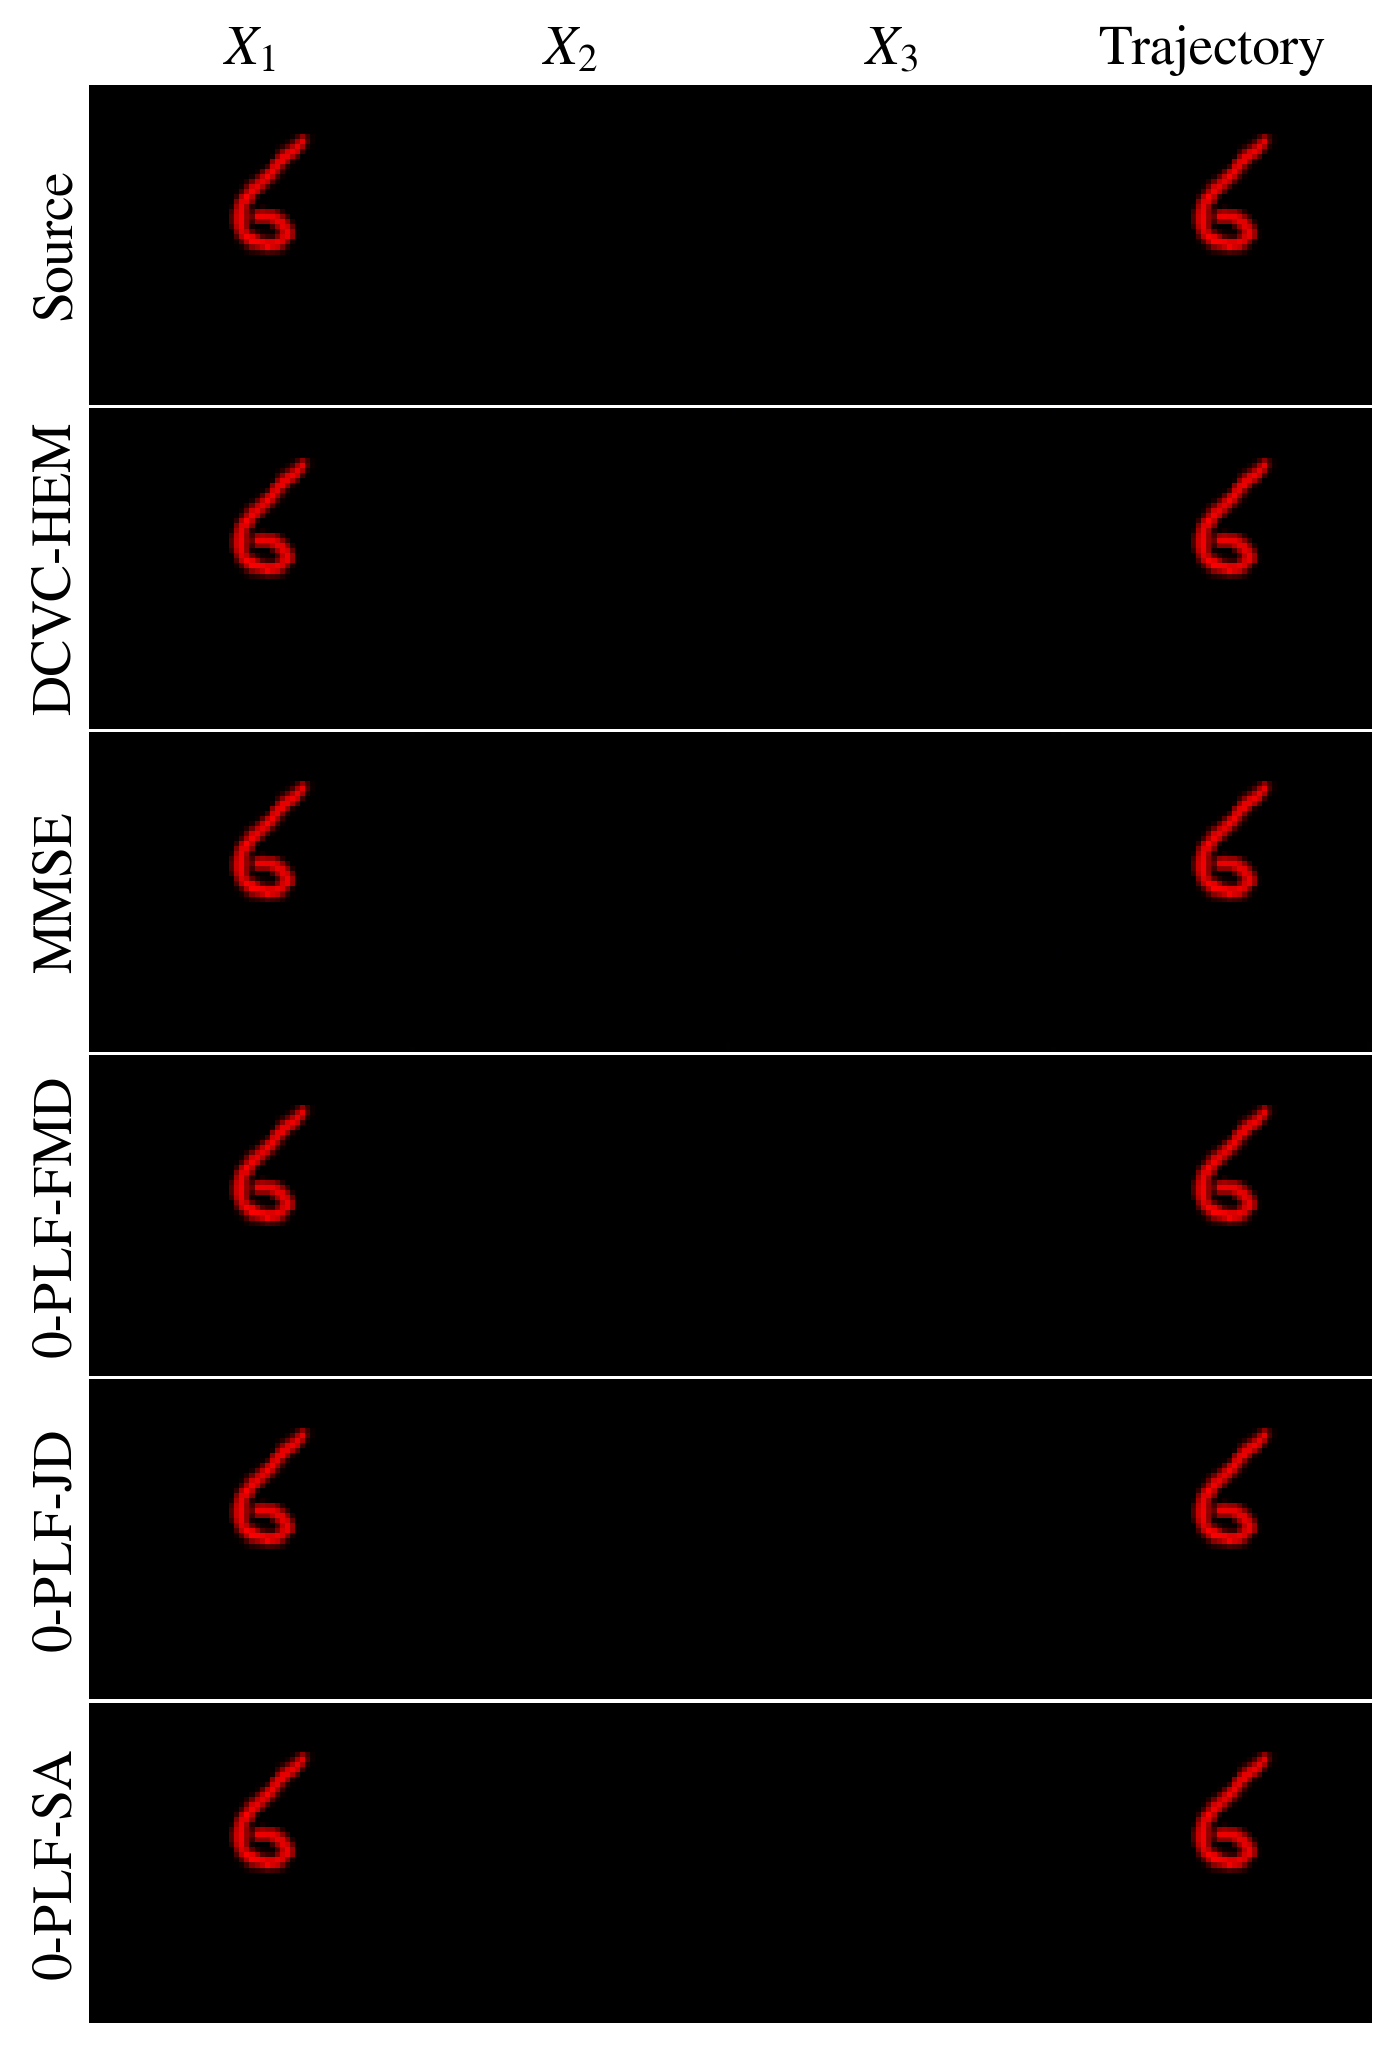

In [11]:
step = 5
dataset = 'mmnist_4_axis_random_sample_step'
loader, _ = get_dataloader(
    data_root='./data/', 
    dataset=dataset, 
    step=step, 
    seq_len=3,
    batch_size=64, 
    num_digits=1
)
x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()

inf_eps1_eps2(
    l_JD1=0.08, l_FMD1=0.04, 
    l_JD2=0.08, l_FMD2=0.08, l_AR2=0.08, 
    eps1=2, eps2=16, x=x, 
    step=step, dataset=dataset
)

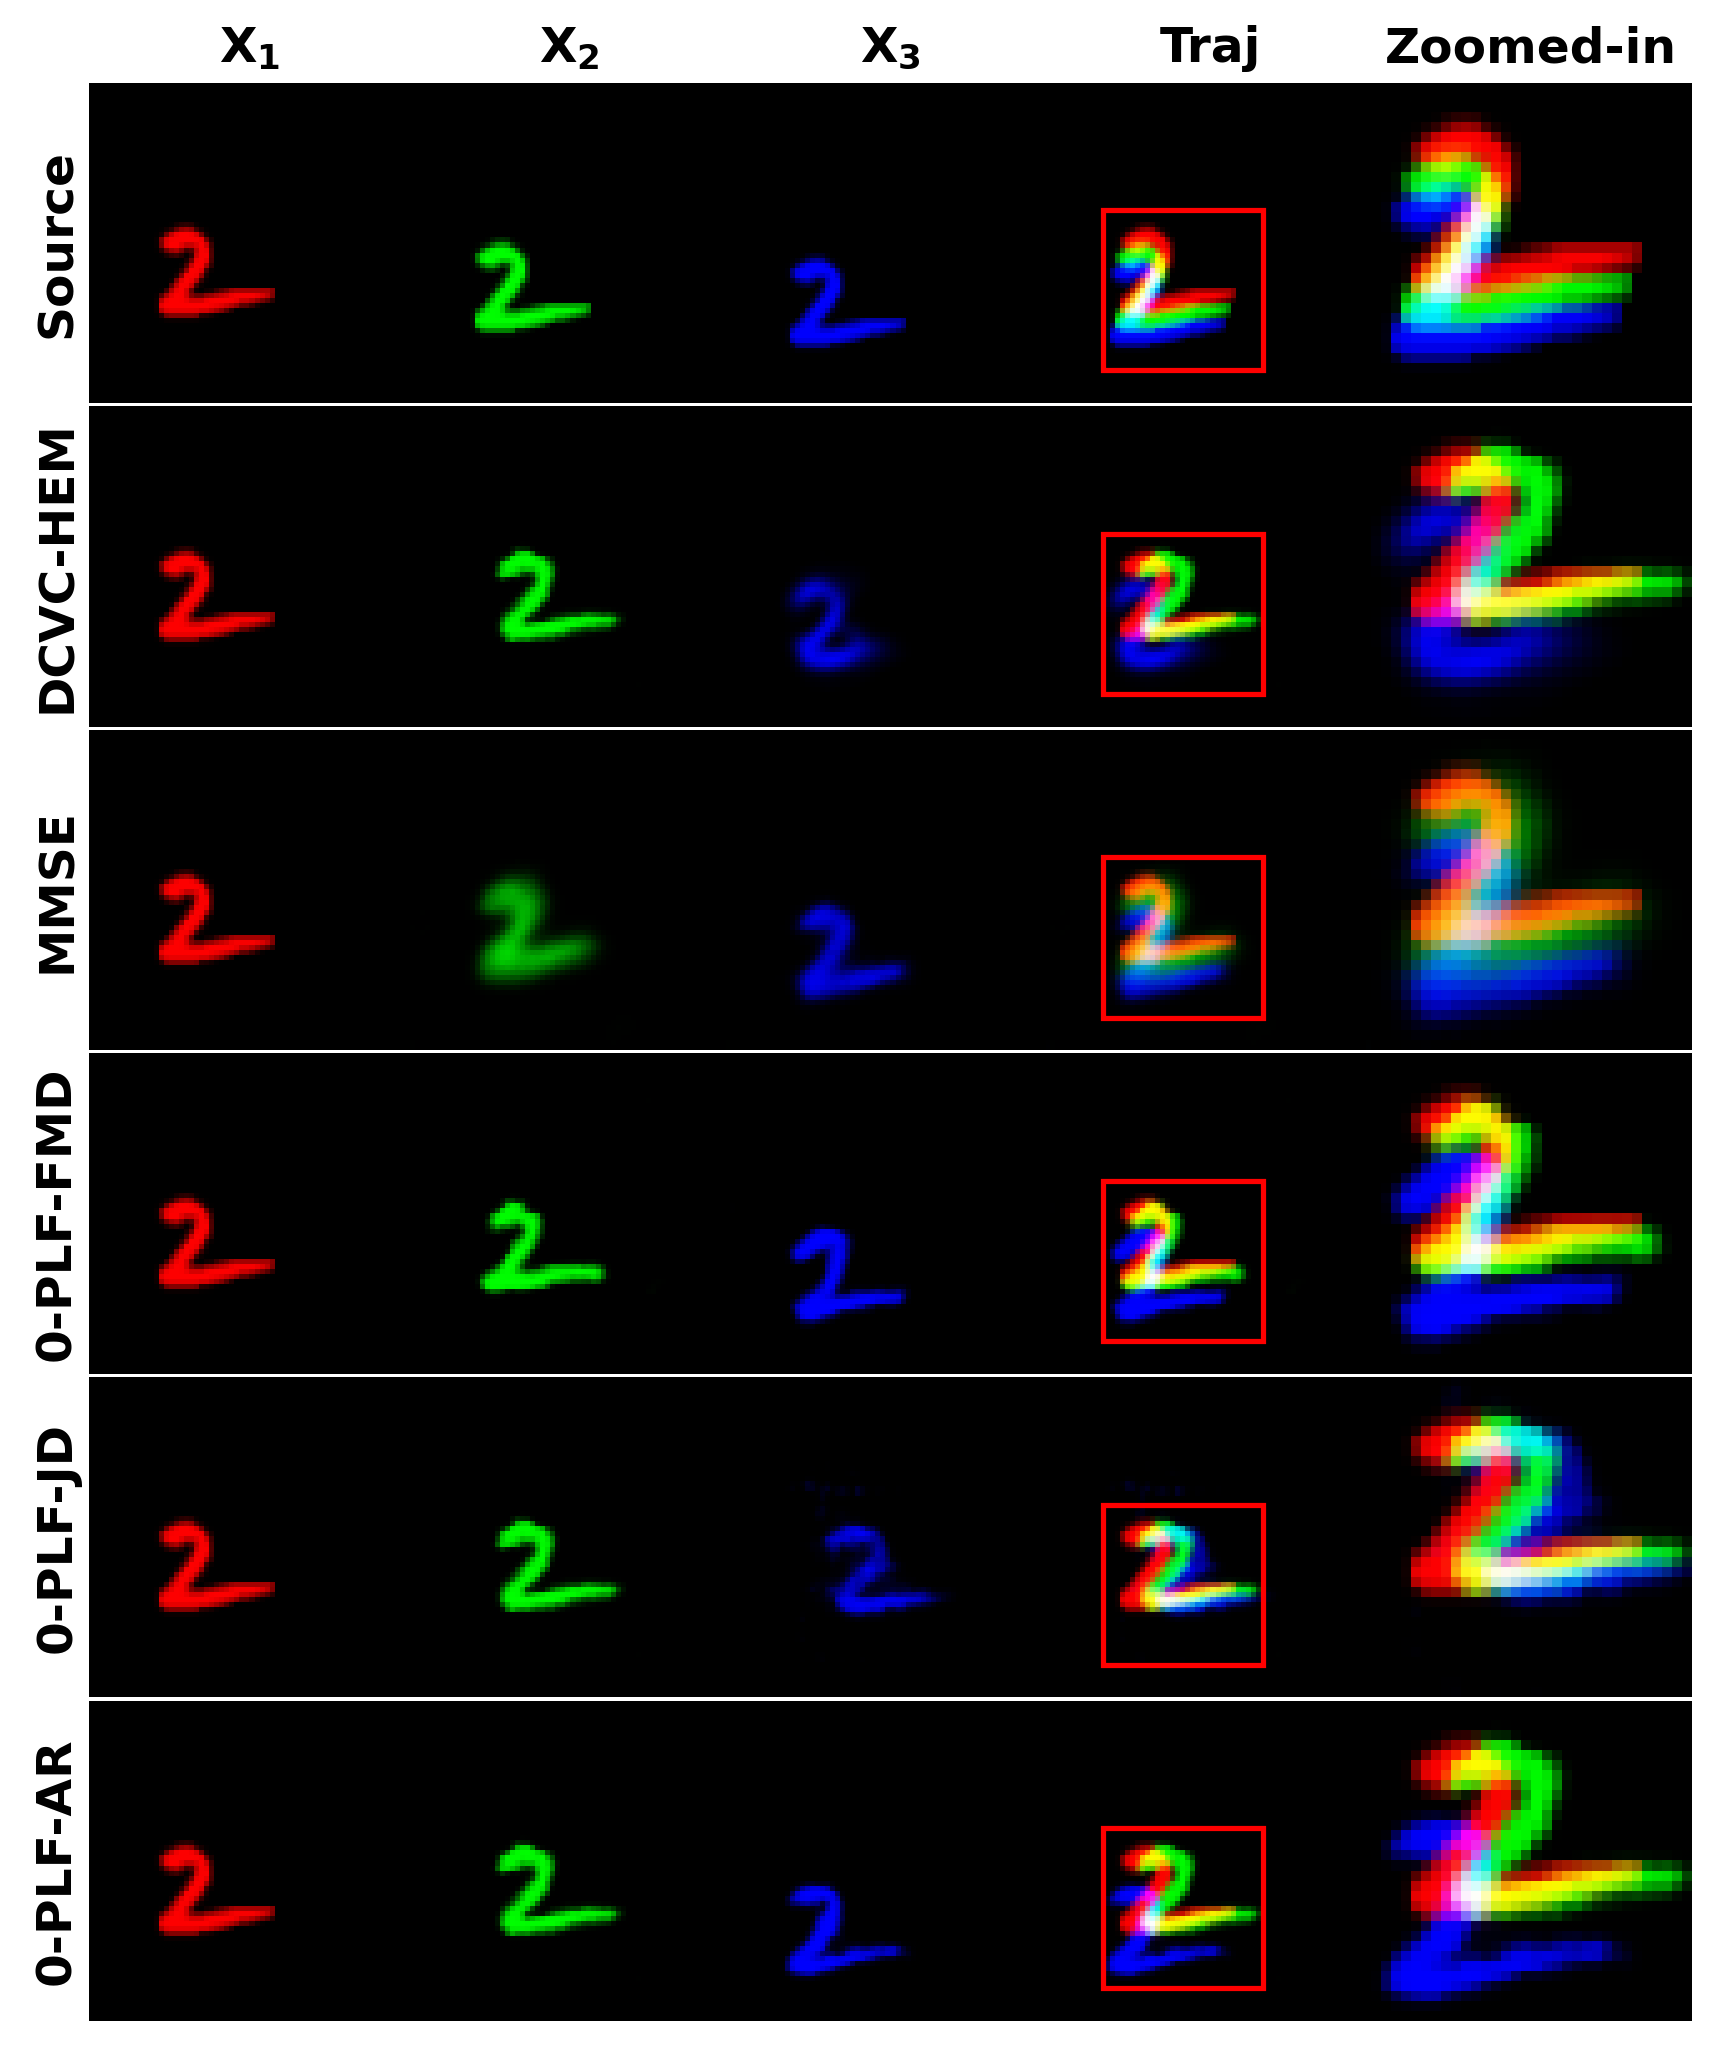

In [83]:
save_path = './reconstructions/inf-eps1-eps2/inf-2-16/step5/'

x0_img = np.array(Image.open(save_path + "x0.png"))
x1_img = np.array(Image.open(save_path + "x1.png"))
x2_img = np.array(Image.open(save_path + "x2.png"))
or_t = np.array(Image.open(save_path + "traj.png"))

x1_MSE_img = np.array(Image.open(save_path + "x1_MSE.png"))
x2_MSE_img = np.array(Image.open(save_path + "x2_MSE.png"))
mse_t = np.array(Image.open(save_path + "traj_MSE.png"))

x1_JD_img = np.array(Image.open(save_path + "x1_JD.png"))
x2_JD_img = np.array(Image.open(save_path + "x2_JD.png"))
jd_t = np.array(Image.open(save_path + "traj_JD.png"))

x1_AR_img = np.array(Image.open(save_path + "x1_AR.png"))
x2_AR_img = np.array(Image.open(save_path + "x2_AR.png"))
ar_t = np.array(Image.open(save_path + "traj_AR.png"))

x1_FMD_img = np.array(Image.open(save_path + "x1_FMD.png"))
x2_FMD_img = np.array(Image.open(save_path + "x2_FMD.png"))
fmd_t = np.array(Image.open(save_path + "traj_FMD.png"))

x2_dcvc_img = np.array(Image.open(save_path + "x2_DCVC.png"))
dcvc_t = np.array(Image.open(save_path + "traj_DCVC.png"))


import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axarr = plt.subplots(
    6, 6, dpi=250, 
    gridspec_kw={
        'wspace': 0.0, 'hspace': 0.01, 'width_ratios': [0.2, 1, 1, 1, 1, 1]}
)
fig.set_size_inches(8.6, 10.27)

for i in range(6):
    for j in range(6):
        axarr[i,j].axis('off')

axarr[0, 1].set_title(r"$\mathbf{X_1}$", fontsize=14, fontweight='bold')
axarr[0, 2].set_title(r"$\mathbf{X_2}$", fontsize=14, fontweight='bold')
axarr[0, 3].set_title(r"$\mathbf{X_3}$", fontsize=14, fontweight='bold')
axarr[0, 4].set_title("Traj", fontsize=14, fontweight='bold')
axarr[0, 5].set_title("Zoomed-in", fontsize=14, fontweight='bold')

axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[0, 0].transAxes, fontsize=14, fontweight='bold')
axarr[1, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[1, 0].transAxes, fontsize=14, fontweight='bold')
axarr[2, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[2, 0].transAxes, fontsize=14, fontweight='bold')
axarr[3, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[3, 0].transAxes, fontsize=14, fontweight='bold')
axarr[4, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[4, 0].transAxes, fontsize=14, fontweight='bold')
axarr[5, 0].text(0.5, 0.5, r"0-PLF-AR", rotation=90, verticalalignment='center', 
                 horizontalalignment='center', transform=axarr[5, 0].transAxes, fontsize=14, fontweight='bold')

images = [
    [x0_img, x1_img, x2_img, or_t],
    [x0_img, x1_JD_img, x2_dcvc_img, dcvc_t],
    [x0_img, x1_MSE_img, x2_MSE_img, mse_t],
    [x0_img, x1_FMD_img, x2_FMD_img, fmd_t],
    [x0_img, x1_JD_img, x2_JD_img, jd_t],
    [x0_img, x1_AR_img, x2_AR_img, ar_t],
]

for i, image_row in enumerate(images):
    for j, img in enumerate(image_row):
        axarr[i, j + 1].imshow(img)

    rect_x, rect_y, rect_width, rect_height = 10, 25, 32, 32
    rect = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, 
                             linewidth=1.5, edgecolor='red', facecolor='none')

    axarr[i, 4].add_patch(rect)

    zoomed_img = image_row[3][rect_y:rect_y + rect_height, rect_x:rect_x + rect_width]
    axarr[i, 5].imshow(zoomed_img)

plt.show()


In [19]:
step = 5
dataset = 'mmnist_4_axis_random_sample_step'
_, loader = get_dataloader(
    data_root='./data/', 
    dataset=dataset, 
    step=step, 
    seq_len=3,
    batch_size=64, 
    num_digits=1
)

pre_path_JD1  = f'./saved_models/inf-eps/step_5/inf-2|lambdaJD_0.08|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD1 = f'./saved_models/inf-eps/step_5/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.04|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE1 = f'./saved_models/inf-eps/step_5/inf-2|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'

pre_path_JD2  = f'./saved_models/inf-eps1-eps2/step_5/inf-2-16|lambdaJD_0.08|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_5/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.08|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_5/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.08|lambdaMSE_1.0|dataset_{dataset}'
pre_path_MSE2 = f'./saved_models/inf-eps1-eps2/step_5/inf-2-16|lambdaJD_0.0|' + \
                f'lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|pretrained_FMD_0.04|dataset_{dataset}'

zdim_1 = 2 // 2
zdim_2 = 16 // 2

#load models for second frame
ssf_JD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2
).to(device).eval()
ssf_FMD1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()
ssf_MSE1 = ScaleSpaceFlow(
    num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2
).to(device).eval()

ssf_JD1  = load_ssf_model(ssf_JD1, pre_path_JD1)
ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)
ssf_MSE1 = load_ssf_model(ssf_MSE1, pre_path_MSE1)

#load models for third frame 
ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)
ssf_MSE2 = ScaleSpaceFlow_R1eps_e2e_3frames(
    num_levels=1, dim=zdim_2, stochastic=True, 
    quantize_latents=True, L=2, single_bit=False, 
    num_c=1, activation=torch.sigmoid
).to(device)

ssf_JD2  = load_ssf_model(ssf_JD2, pre_path_JD2)
ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)
ssf_MSE2 = load_ssf_model(ssf_MSE2, pre_path_MSE2)

mse_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
jd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
fmd_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
ar_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}
dcvc_eval = {'2_psnr':0, '3_psnr': 0, '2_lpips': 0, '3_lpips': 0}

length = len(loader)
with torch.no_grad():
    for x in tqdm(loader):
        x = x.permute(0, 4, 1, 2, 3).to(device).float()

        # original frames
        x0 = x[:, :, 0, ...]
        x1 = x[:, :, 1, ...]
        x2 = x[:, :, 2, ...]

        # second frames
        x1_hat_JD  = ssf_JD1(x1, x0)
        x1_hat_AR = ssf_JD1(x1, x0)
        x1_hat_FMD = ssf_FMD1(x1, x0)
        x1_hat_MSE = ssf_MSE1(x1, x0)

        # third frames
        x2_hat_JD  = ssf_JD2(x2, x1_hat_JD, x0, x1_hat_JD)
        x2_hat_AR = ssf_NEW2(x2, x1_hat_AR, x0, x1_hat_AR)
        x2_hat_FMD = ssf_FMD2(x2, x1_hat_FMD, x0, x1_hat_FMD)
        x2_hat_MSE = ssf_MSE2(x2, x1_hat_MSE, x0, x1_hat_MSE)

        x2_hat_dcvc = run_dcvc_test(x1_hat_JD, x2)

        mse_eval['2_psnr'] += PSNR(x1, x1_hat_MSE)
        mse_eval['3_psnr'] += PSNR(x2, x2_hat_MSE)
        mse_eval['2_lpips'] += LPIPS(x1, x1_hat_MSE)
        mse_eval['3_lpips'] += LPIPS(x2, x2_hat_MSE)

        jd_eval['2_psnr'] += PSNR(x1, x1_hat_JD)
        jd_eval['3_psnr'] += PSNR(x2, x2_hat_JD)
        jd_eval['2_lpips'] += LPIPS(x1, x1_hat_JD)
        jd_eval['3_lpips'] += LPIPS(x2, x2_hat_JD)

        fmd_eval['2_psnr'] += PSNR(x1, x1_hat_FMD)
        fmd_eval['3_psnr'] += PSNR(x2, x2_hat_FMD)
        fmd_eval['2_lpips'] += LPIPS(x1, x1_hat_FMD)
        fmd_eval['3_lpips'] += LPIPS(x2, x2_hat_FMD)

        ar_eval['2_psnr'] += PSNR(x1, x1_hat_AR)
        ar_eval['3_psnr'] += PSNR(x2, x2_hat_AR)
        ar_eval['2_lpips'] += LPIPS(x1, x1_hat_AR)
        ar_eval['3_lpips'] += LPIPS(x2, x2_hat_AR)

        dcvc_eval['3_psnr'] += PSNR(x2, x2_hat_dcvc)
        dcvc_eval['3_lpips'] += LPIPS(x2, x2_hat_dcvc)

print('Second frame PSNR:  ' + \
      f'MSE {mse_eval["2_psnr"] / length:.4f} | JD {jd_eval["2_psnr"] / length:.4f} | ' + \
      f'FMD {fmd_eval["2_psnr"] / length:.4f} | AR {ar_eval["2_psnr"] / length:.4f}')
print('Second frame LPIPS: ' + \
      f'MSE {mse_eval["2_lpips"] / length:.4f} | JD {jd_eval["2_lpips"] / length:.4f} | ' + \
      f'FMD {fmd_eval["2_lpips"] / length:.4f} | AR {ar_eval["2_lpips"] / length:.4f}')

print('Third frame PSNR:  ' + \
      f'MSE {mse_eval["3_psnr"] / length:.4f} | JD {jd_eval["3_psnr"] / length:.4f} | ' + \
      f'FMD {fmd_eval["3_psnr"] / length:.4f} | AR {ar_eval["3_psnr"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["3_psnr"] / length:.4f}')
print('Third frame LPIPS: ' + \
      f'MSE {mse_eval["3_lpips"] / length:.4f} | JD {jd_eval["3_lpips"] / length:.4f} | ' + \
      f'FMD {fmd_eval["3_lpips"] / length:.4f} | AR {ar_eval["3_lpips"] / length:.4f} | ' + \
      f'DCVC {dcvc_eval["3_lpips"] / length:.4f}')

Finished Loading MovingMNIST_4_axis_random_sample_step!
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


100%|██████████| 937/937 [17:45<00:00,  1.14s/it]

Second frame PSNR:  MSE 20.5285 | JD 18.0365 | FMD 18.8061 | AR 18.0365
Second frame LPIPS: MSE 0.0996 | JD 0.0473 | FMD 0.0463 | AR 0.0473
Third frame PSNR:  MSE 23.3969 | JD 16.2145 | FMD 21.6049 | AR 24.0660 | DCVC 23.8770
Third frame LPIPS: MSE 0.0513 | JD 0.0933 | FMD 0.0343 | AR 0.0242 | DCVC 0.0571
